# Visualising decisions of a basic CNN 

## Motivation
The increased predictive accuracy of ML models has brought with it its own set of problems, 
the most significant one being the lack of transparency in the process by which a model 
arrives at a conclusion. These opaque or black-box models hide their inner workings from the 
user thereby preventing technical or domain experts from being able to verify and understand 
the reasoning of the system and how decisions are made [1]. This lack of transparency can 
lead to severe consequences when algorithms are used in situations like determining bail, air-quality measures, medicine, energy reliability, finance and in other domains [2]. Entrusting 
important decisions to a system that cannot explain itself and cannot be explained by humans 
presents evident dangers [1].

For this notebook, I will be using a basic pre-trained model. <br/>
The training notebook is available at: <br/>
https://www.kaggle.com/mreenav/plant-pathology-basic-cnn

You are free to train your own models and visualize their decision boundaries! Just add your saved model as a dataset to this notebook and load it in. 

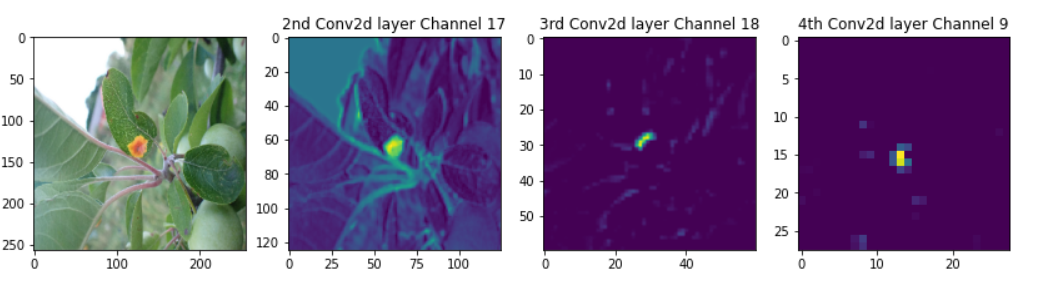

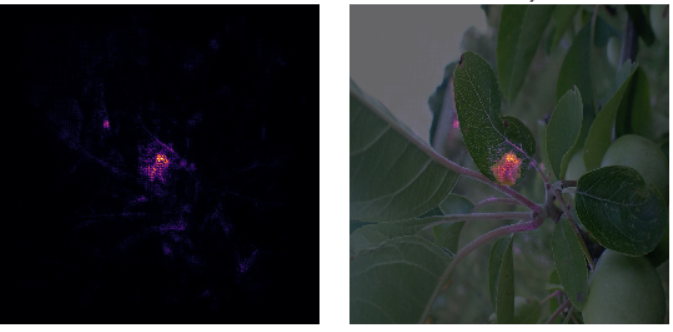

**Version History**
* Version 1: Intermediate Activations of Convolutions
* Version 2: Integrated Gradients


In [ ]:
#Import the dependencies we will require
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from PIL import Image
import tensorflow_addons as tfa

In [ ]:
#Set the paths for the data
path = '../input/plant-pathology-2021-fgvc8/'
train_dir = path + 'train_images/'
test_dir = path + 'test_images/'

In [ ]:
#Read the dataframe
df = pd.read_csv('../input/plant-pathology-2021-fgvc8/train.csv')

In [ ]:
#Load the model. Replace this with your the path to you own model if you like
model = keras.models.load_model('../input/plant-pathology-basic-cnn/best_model.h5')

In [ ]:
# Converting to multi-label problem
# This is required because I trained my CNN model as a multi-label problem. If you trained it as multi-class, 
# or followed any other labelling conventions, please modify this code (or ignore it all together)
# (credits: https://www.kaggle.com/shanmukh05/plant-pathology-2k21-baseline-tpu-training)

count_dict = df.labels.value_counts()
label2id = {
    'scab': 0,
    'frog_eye_leaf_spot' : 1,
    'rust' : 2,
    'complex' : 3,
    'powdery_mildew' : 4,
}
NUM_CLASS = len(label2id)
id2label = dict([(value, key) for key, value in label2id.items()])
df["labels"] = df["labels"].map(lambda x : [i for i in x.split(" ") if i != "healthy"])
df["labels"] = df["labels"].map(lambda x : [label2id[i] for i in x])
df.head()

In [ ]:
image_datagen = ImageDataGenerator(rescale = 1./255)
image_generator = image_datagen.flow_from_dataframe(dataframe = df,
                                                   directory = train_dir,
                                                   target_size = (256,256),
                                                   x_col = 'image',
                                                   y_col = 'labels',
                                                   batch_size = 128,
                                                   color_mode = 'rgb',
                                                   class_mode = 'categorical',
                                                   seed = 3)

In [ ]:
#Get the first batch of images
x_batch, y_batch = next(image_generator)

In [ ]:
# This is helper code required to convert my predictions back to their labels
def convert_to_text(pred):
    labels = ""
    indices = np.where(pred == 1)[0]
    for index in indices:
        labels = labels + id2label[index] + " "
    if labels == "":
        labels = "healthy"    
    return labels 

def convert_pred_to_text(pred):
    labels = []
    for row in pred:
        text_pred = ""
        if row != []:
            for i,v in enumerate(row):
                text_pred = text_pred + id2label[v] + " "
        else:
            text_pred = "healthy"
        text_pred = text_pred.strip()
        labels.append(text_pred)
    return labels 

label2id = {
    'scab': 0,
    'frog_eye_leaf_spot' : 1,
    'rust' : 2,
    'complex' : 3,
    'powdery_mildew' : 4,
}
NUM_CLASS = len(label2id)
id2label = dict([(value, key) for key, value in label2id.items()])

def convert_image_to_tensor(img):
    return np.expand_dims(keras.preprocessing.image.img_to_array(img), axis = 0)

def plot_batch(x_batch, y_batch, number_of_images):
    for i in range (0, number_of_images):
        image = x_batch[i]
        plt.imshow(image)
        plt.title(convert_to_text(y_batch[i]))
        plt.show()

In [ ]:
# Let's plot the first 20 images in our batch
plot_batch(x_batch, y_batch, 20)

In [ ]:
# Let's take a look at the architecture of our pre-trained CNN
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes = True, show_layer_names = True)

In [ ]:
#Predictions helper code
def get_labels_from_pred(pred):
    threshold = {0: 0.57,
             1: 0.41,
             2: 0.36,
             3: 0.37,
             4: 0.17}
    labels = []
    for row in pred:
        row_label = []
        for i,v in enumerate(row):
            if v > threshold[i]:
                row_label.append(i)
        labels.append(row_label)
    return labels


## Visualizing activations of intermediate convolutions 

In [ ]:
# Lets consider the first ten layers
layer_outputs = [layer.output for layer in model.layers[:10]] 
activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [ ]:
# Let's choose an image to predict
# For this example I will choose the 3rd image in the batch
img = x_batch[5]
img_tensor = convert_image_to_tensor(x_batch[5])
predicted_output = model.predict(img_tensor)
predicted_labels = get_labels_from_pred(predicted_output)
plt.imshow(img)
print("Actual label %s" %(convert_to_text(y_batch[5])))
print("Predicted label %s" %(convert_pred_to_text(predicted_labels)))

In [ ]:
#Let's get run the image through the activation model that we have defined earlier. This will help us to visualize
#the intermediate activations
activations = activation_model.predict(img_tensor) 


In [ ]:
#Lets visualize a single activation say of the layer conv2d
first_layer_activation = activations[0]
print(first_layer_activation.shape)

In [ ]:
#Lets try to plot a few channels of the activation of the conv2d layer (first convolution layer) 
#I am choosing channels numbered 9, 10, and 11
fig = plt.figure(figsize=(14,14))

fig.add_subplot(1, 4, 1)
plt.imshow(x_batch[5])

fig.add_subplot(1, 4, 2)
plt.imshow(first_layer_activation[0, :, :, 9])
plt.title('Channel 8')

fig.add_subplot(1, 4, 3)
plt.imshow(first_layer_activation[0, :, :, 10])
plt.title('Channel 9')

fig.add_subplot(1, 4, 4)
plt.imshow(first_layer_activation[0, :, :, 11])
plt.title('Channel 10')

##### Channel 9 seems to have correctly identified the spots indicative of the rust while channel 8 has not learnt much useful information. Channel 10 is partially activated by the rust spot but parts of the background are similaryly activated.<br/>
##### As we go deeper into the CNN, we will see that the convolutions get better at understanding what causes the disease. <br/>
##### Let's take a look at all the layers and zoom in on any layer that we find interesting.

In [ ]:
# Credits: https://github.com/gabrielpierobon/cnnshapes/blob/master/README.md
layer_names = []
for layer in model.layers[:10]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16
plt.imshow(x_batch[5])
plt.title(convert_to_text(y_batch[5]))
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 2. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

##### It seems that the activations get increasingly abstract as we go deeper into the neural net. Manual inspection of these layers does not seem to be a very good idea for us and there are some other ways to interpret the neural network. However, just for fun, let's take a look at some of interesting activations 

In [ ]:
third_layer_activation = activations[2]
fifth_layer_activation = activations[4]
seventh_layer_activation = activations[6]
fig = plt.figure(figsize=(14,14))

fig.add_subplot(1, 4, 1)
plt.imshow(x_batch[5])

fig.add_subplot(1, 4, 2)
plt.imshow(third_layer_activation[0, :, :, 16])
plt.title('2nd Conv2d layer Channel 17')

fig.add_subplot(1, 4, 3)
plt.imshow(fifth_layer_activation[0, :, :, 17])
plt.title('3rd Conv2d layer Channel 18')

fig.add_subplot(1, 4, 4)
plt.imshow(seventh_layer_activation[0, :, :, 8])
plt.title('4th Conv2d layer Channel 9')

# Integrated Gradients


[3] proposed a new method called Integrated Gradients that allows us to view the attributions of the features towards making a predictions while retaining sensitivity and implementation invariance. This method, called integrated gradients, is defined as the path integral of the gradients along the straight line path between the original input and the baseline input. For image processing, the baseline input can be considered as a black image.

Code adapted from: https://www.tensorflow.org/tutorials/interpretability/integrated_gradients

In [ ]:
baseline = tf.zeros(shape=(256,256,3))
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

In [ ]:
def interpolate_images(baseline,
                       image,
                       alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  return images

In [ ]:
interpolated_images = interpolate_images(
    baseline=baseline,
    image=x_batch[5],
    alphas=alphas)

In [ ]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout();

In [ ]:
def compute_gradients(images, target_class_idx):
  with tf.GradientTape() as tape:
    tape.watch(images)
    logits = model(images)
    probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
  return tape.gradient(probs, images)

In [ ]:
def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

In [ ]:
path_gradients = compute_gradients(
    images=interpolated_images,
    target_class_idx=2)

In [ ]:
ig = integral_approximation(
    gradients=path_gradients)

In [ ]:
@tf.function
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
  # 1. Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Initialize TensorArray outside loop to collect gradients.    
  gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)

  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    # 2. Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # 3. Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)

    # Write batch indices and gradients to extend TensorArray.
    gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)    

  # Stack path gradients together row-wise into single tensor.
  total_gradients = gradient_batches.stack()

  # 4. Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # 5. Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients

In [ ]:
ig_attributions = integrated_gradients(baseline=baseline,
                                       image=x_batch[5],
                                       target_class_idx=2,
                                       m_steps=240)

In [ ]:
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

  attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

  axs[0, 0].set_title('Baseline image')
  axs[0, 0].imshow(baseline)
  axs[0, 0].axis('off')

  axs[0, 1].set_title('Original image')
  axs[0, 1].imshow(image)
  axs[0, 1].axis('off')

  axs[1, 0].set_title('Attribution mask')
  axs[1, 0].imshow(attribution_mask, cmap=cmap)
  axs[1, 0].axis('off')

  axs[1, 1].set_title('Overlay')
  axs[1, 1].imshow(attribution_mask, cmap=cmap)
  axs[1, 1].imshow(image, alpha=overlay_alpha)
  axs[1, 1].axis('off')

  plt.tight_layout()
  return fig

In [ ]:
_ = plot_img_attributions(image=x_batch[5],
                          baseline=baseline,
                          target_class_idx=2,
                          m_steps=240,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

By using integrated gradients, we are able to find an attribution mask for the features (pixels) that contribute towards our prediction of this image as rust. We can overlay this mask with the original image in order to provide a visual guidance to end users to understand the decisions taken by the deep neural network.

## References
[1] Carvalho, Diogo V., Eduardo M. Pereira, and Jaime S. Cardoso. "Machine learning 
interpretability: A survey on methods and metrics." Electronics 8, no. 8 (2019): 832.

[2] Rudin, Cynthia. "Stop explaining black box machine learning models for high stakes 
decisions and use interpretable models instead." Nature Machine Intelligence 1, no. 5 (2019): 
206-215.

[3] Sundararajan, Mukund, Ankur Taly, and Qiqi Yan. "Axiomatic attribution for deep networks." In International Conference on Machine Learning, pp. 3319-3328. PMLR, 2017.